# Fine tuning with S-BERT

The models will be saved in this folder - https://drive.google.com/drive/folders/1ui5rywdrDdbBUeHph9AaA0VpfX01bbRe?usp=sharing


# Setup

In [ ]:
# Install necessary libraries
! pip install --quiet \
  scprep\
  spacy==3.0.5 \
  wandb \
  onnx \
  onnxruntime \
  sentence_transformers==1.0.2 \
  phate==1.0.7 && \
  python -m spacy download es_core_news_lg

# Setup connection with your own google drive
from google.colab import drive
drive.mount('/content/drive')

# Restarting the runtime is required for the libraries to be active in the notebook
import os
os.kill(os.getpid(), 9)

2021-04-20 17:19:19.248523: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_lg')


In [1]:
# Clone branch from github
!rm -rf policy-data-analyzer/
! branch_name='wandb-experiments' && \
  git clone --branch $branch_name https://github.com/wri-dssg/policy-data-analyzer.git

Cloning into 'policy-data-analyzer'...
remote: Enumerating objects: 5773, done.
remote: Counting objects: 100% (514/514), done.
remote: Compressing objects: 100% (388/388), done.
remote: Total 5773 (delta 291), reused 275 (delta 123), pack-reused 5259
Receiving objects: 100% (5773/5773), 206.13 MiB | 19.55 MiB/s, done.
Resolving deltas: 100% (3054/3054), done.
Checking out files: 100% (1004/1004), done.


In [2]:
#If you run this cell more than once, comment out this line because you are already in this folder and you will get an error
import os
os.chdir("policy-data-analyzer") 

from tasks.fine_tuning_sbert.src.loops import *

Using the GPU


# Data Loading

In [3]:
"""
MAKE SURE THAT THIS IS ALWAYS YOUR INDIVIDUAL NUMBER (FOR REASONS TO NOT OVERWRITE DATA)
"""

GLOBAL_EXPERIMENT_NUMBER = 15

Please do not overwrite existing models and their results from previous experiments
You are writing to Experiment # 10


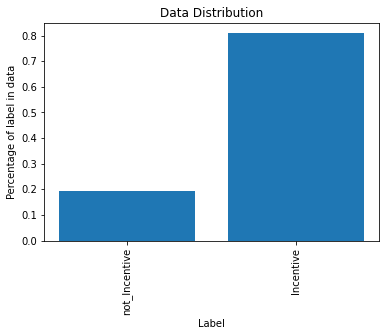

Label counts:
{'not_Incentive': 0.19183168316831684, 'Incentive': 0.8081683168316832}


In [5]:
experiment = "EXP30"
classifier = "Binary"

base_path = "/content/drive/MyDrive/Official Folder of WRI Latin America Project/WRI-LatinAmerica-Talent"

data_path = f"{base_path}/Cristina_Policy_Files/Tagged_sentence_lists/Spanish/datasets/{classifier}"

results_save_path = f"{base_path}/Modeling/Model_reproducibility/Model_results/{classifier}ClassificationExperiments/{GLOBAL_EXPERIMENT_NUMBER}"

if not os.path.exists(results_save_path):
    os.makedirs(results_save_path)
    print(f"Making new experiment folder for experiment # {GLOBAL_EXPERIMENT_NUMBER}")
else:
    print("Please do not overwrite existing models and their results from previous experiments")
    print(f"You are writing to Experiment # {GLOBAL_EXPERIMENT_NUMBER}")

train_sents, train_labels, test_sents, test_labels = load_dataset(data_path, experiment)
label_names = unique_labels(train_labels)

make_dataset_public(train_sents, train_labels, label_names)

numeric_train_labels = labels2numeric(train_labels, label_names)

plot_data_distribution(numeric_train_labels, label_names)

In [ ]:
# class balance/imbalance for test set
label_names_test = unique_labels(test_labels)
numeric_train_labels_test = labels2numeric(test_labels, label_names_test)

plot_data_distribution(numeric_train_labels_test, label_names_test)

# Grid Search Fine Tuning

Stores only the parameters used in the grid search, together with the results - no model is stored

In [6]:
# PASTE YOUR WEIGHTS & BIASES KEY HERE
wandb_key = ''
group_desc = ''
job_type = ''

os.environ['WANDB_JOB_TYPE'] = job_type
os.environ['WANDB_RUN_GROUP'] = group_desc
os.environ['WANDB_API_KEY'] = wandb_key

In [ ]:
# wandb sweeps
sweep_config = {
    'method': 'random',
    "name": "SBERT hyperparam tuning"
}

metric = {
    'name': 'Weighted F1 validation',
    'goal': 'maximize'   
}

parameters_dict = {
    "dev_perc": {
        "values": [0.20, 0.25]
    },
    'model_name': {
        'values': ['paraphrase-xlm-r-multilingual-v1', 'stsb-xlm-r-multilingual', 'quora-distilbert-multilingual', 'distiluse-base-multilingual-sed-v2']
    },
    'seeds': {
        'values': [10, 11, 12]
    },
    # all values below are set but not varies
    "max_num_epochs": {
        "value": 10
    },
    "baseline": {
        "value": 0.001
    },
    "patience": {
        "value": 5
    },
    "eval_classifier": {
        "value": "SBERT"
    },
    "output_path": {
        "value": results_save_path
    },
    "group": {
        "value": "sweep-1"
    }
}

sweep_config['parameters'] = parameters_dict
sweep_config['metric'] = metric

import pprint

pprint.pprint(sweep_config)

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="WRI", entity="ramanshsharma")

In [ ]:
wandb.agent(sweep_id, grid_search_fine_tune_sbert, count=5)

## Loading saved model

In [ ]:
saved_model = EarlyStoppingSentenceTransformer(model_name_or_path=results_save_path)
str(saved_model)

'EarlyStoppingSentenceTransformer(\n  (0): Transformer(\n    (auto_model): XLMRobertaModel(\n      (embeddings): RobertaEmbeddings(\n        (word_embeddings): Embedding(250002, 768, padding_idx=1)\n        (position_embeddings): Embedding(514, 768, padding_idx=1)\n        (token_type_embeddings): Embedding(1, 768)\n        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)\n        (dropout): Dropout(p=0.1, inplace=False)\n      )\n      (encoder): RobertaEncoder(\n        (layer): ModuleList(\n          (0): RobertaLayer(\n            (attention): RobertaAttention(\n              (self): RobertaSelfAttention(\n                (query): Linear(in_features=768, out_features=768, bias=True)\n                (key): Linear(in_features=768, out_features=768, bias=True)\n                (value): Linear(in_features=768, out_features=768, bias=True)\n                (dropout): Dropout(p=0.1, inplace=False)\n              )\n              (output): RobertaSelfOutput(\n          

In [ ]:
torch.save(saved_model, 'statedict.pt')

In [ ]:
newmodel = torch.load('statedict.pt')
newmodel.eval()
str(newmodel)

## Testing model on test set

In [ ]:
numeric_test_labels = labels2numeric(test_labels, label_names)
evaluate_using_sbert(newmodel, test_sents, test_labels, label_names,
                         None, numeric_test_labels, output_path=results_save_path, testing=True)

## Trying to load a model with wandb

In [ ]:
run = wandb.init(project='WRI', entity='ramanshsharma')

artifact = run.use_artifact('ramanshsharma/WRI/model:v0', type='model')
artifact_dir = artifact.download()

run.join()

## Define evaluation classifier (optional)
If using a sklearn or other non-SBERT model as a classifier for evaluation, uncomment one of these models (or add your own and name it `clf`)

In [ ]:
from lightgbm import LGBMClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

In [ ]:
clf = LGBMClassifier(n_estimators=2000,
                      feature_fraction=0.06,
                      bagging_fraction=0.67,
                      bagging_freq=1,
                      verbose=0,
                      n_jobs=6,
                      random_state=69420)

clf = svm.SVC(gamma=0.001, C=100.)

clf = RandomForestClassifier(n_estimators=500,
                            max_features=0.06,
                            n_jobs=6,
                            random_state=69420)